In [1]:
import requests
import urllib.request
def kakao_reverse_geocode(lat, lon):
    addr_list = []
    roadaddr_list =[]
    building_list =[]
    api_key = 'KakaoAK 5bc7785bedf372180f58929a0899232f'
    url = 'https://dapi.kakao.com/v2/local/geo/coord2address.json?&x=' + str(lon) +'&y=' + str(lat) 
    option = '&sort=distance&input_coord=WGS84'
    result = requests.get(url+option, headers={'Authorization': api_key}).json()
    #print(result)
    match_first = result['documents'][0]
    #print(match_first)
    if match_first["road_address"]== None:
        addr_list.append(match_first["address"]["address_name"])
        roadaddr_list.append("no results")
        building_list.append("no results")
        return addr_list,roadaddr_list,building_list
    else:
        addr_list.append(match_first["address"]["address_name"])
        roadaddr_list.append(match_first["road_address"]["address_name"])
        building_list.append(match_first["road_address"]["building_name"])
        return addr_list, roadaddr_list,building_list

In [2]:
def kakao_get_place(place_name):
    place = []
    addr = []
    type_list = []
    lat = []
    lon = []
    api_key = 'KakaoAK 5bc7785bedf372180f58929a0899232f'
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?&query='
    query = urllib.parse.quote(place_name)
    for j in range(1,4):
        result = requests.get(url+query+"&page=" + str(j), headers={'Authorization': api_key}).json()
        if len(result['documents']) != 0:
            for i in range(len(result['documents'])):
                #print(result['documents'][i])
                if result['documents'][i]["place_name"] !="":
                    if result['documents'][i]["place_name"] not in place:
                        place.append(result['documents'][i]["place_name"])
                        addr.append(result['documents'][i]["address_name"])
                        type_list.append(result['documents'][i]['category_name'])
                        lat.append(result['documents'][i]['y'])
                        lon.append(result['documents'][i]['x'])
        else:
            place.append("no results")
    return place,type_list,addr,lat,lon

In [3]:
def kakao_get_addr(addr):
    lat = []
    lon = []
    api_key = 'KakaoAK 5bc7785bedf372180f58929a0899232f'
    url = 'https://dapi.kakao.com/v2/local/search/address.json?&query='
    query = urllib.parse.quote(addr)
    result = requests.get(url+query, headers={'Authorization': api_key}).json()
    lat.append(result["documents"][0]["y"])
    lon.append(result["documents"][0]["x"])
    return lat, lon

In [4]:
def kakao_get_place_addr(addr):
    place = []
    api_key = 'KakaoAK 5bc7785bedf372180f58929a0899232f'
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?&query='
    query = urllib.parse.quote(addr)
    for j in range(1,4):
        result = requests.get(url+query+"&page=" + str(j), headers={'Authorization': api_key}).json()
        if len(result['documents']) != 0:
            for i in range(len(result['documents'])):
                #print(result['documents'][i])
                if result['documents'][i]["place_name"] !="":
                    if result['documents'][i]["place_name"] not in place:
                        place.append(result['documents'][i]["place_name"])
        else:
            place.append("no results")
    return place

In [5]:
def remove_0(df):
    for i in range(len(df)):
        if df['lat'][i] == 0 or df['lon'][i] == 0:
            df = df.drop(i)
        
    df = df.reset_index(drop=True)
    return df

In [6]:
def get_xdata(df):
    x = df.iloc[:, [1, 2]].values
    return x

In [7]:
def get_cluster_count(cluster):
    cluster_list = []
    for i in cluster:
        if i not in cluster_list:
            cluster_list.append(i)
    return cluster_list

In [8]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [9]:
from haversine import haversine
def add_cluster(m, point_id, eps):
    cluster = []
    for i in range(0, len(x)):
 #       print(m[point_id])
        dist = euclidean_distance(m[point_id],m[i])
        #dist = haversine(m[point_id],m[i])
        
        if dist <= eps:
            cluster.append(i)
    return cluster

In [10]:
import random

def expand_cluster(m, classifications, index, cluster_id, eps, min_points):
    index = random.randint(0,len(m)-1)
    while (classifications[index] != 0):
        index = (index + 1) % len(classifications)
    cluster = add_cluster(m, index, eps)
    
    if len(cluster) < min_points:
        classifications[index] = -1
        return False
    else:
        #print(cluster_id)
        classifications[index] = cluster_id
        for i in cluster:
            classifications[i] = cluster_id
            
        while len(cluster) > 0:
            current_point = cluster[0]
            results = add_cluster(m, current_point, eps)
            if len(results) >= min_points:
                for i in range(0, len(results)):
                    result_point = results[i]
                    if classifications[result_point] == 0:
                        cluster.append(result_point)
                    classifications[result_point] = cluster_id
            cluster = cluster[index + 1:]
        return True

In [11]:
def dbscan(m, eps, min_points):
    cluster_id = 1
    n_points = m.shape[0]
    classifications = [0] * n_points
    for i in range(0, n_points):
        if classifications[i] == 0:
            if expand_cluster(m, classifications, i, cluster_id, eps, min_points):
                cluster_id = cluster_id + 1
    return classifications

In [12]:
import pymssql
from math import *
import pandas as pd
import numpy as np 

# DB 서버 주소
server = '203.234.62.143'
# 데이터 베이스 이름
database = 'test'
# 접속 유저명
username = 'sojin'
# 접속 유저 패스워드
password = '1234'

conn = pymssql.connect(server , username, password, database)
curs = conn.cursor()

#curs.execute()

time1 = "2021-03-10 10:43:55.000"
time2 = "2021-03-10 12:09:04.000"
# sql = 'SELECT TOP (1000) *  FROM lifelog_manual'
sql = "SELECT * FROM dataset WHERE time between '" + time1 + "' and '" + time2 +"' order by time asc;"
df = pd.read_sql(sql, con = conn)

conn.close()

In [397]:
df = pd.read_csv(r"./gps데이터/Log_20210806_2.txt",sep=',', header = None, names = ['time', 'lat','lon','x','y','z','speed','svm','step_count','acttype'])
c = 2
df

,time,lat,lon,x,y,z,speed,svm,step_count,acttype
0,2021-08-06 09:58:57,0.000000,0.000000,0.0,0.0,0.0,0.000000,9.897770,0,NaN
1,2021-08-06 09:59:02,35.944527,126.685804,0.0,0.0,0.0,1.027083,9.157484,15,NaN
2,2021-08-06 09:59:07,35.944526,126.685841,0.0,0.0,0.0,0.835968,9.318807,18,NaN
3,2021-08-06 09:59:12,35.944538,126.685816,0.0,0.0,0.0,0.348030,9.830459,18,NaN
4,2021-08-06 09:59:17,35.944544,126.685810,0.0,0.0,0.0,0.259963,10.932160,18,NaN
...,...,...,...,...,...,...,...,...,...,...
686,2021-08-06 10:56:07,35.945217,126.682719,0.0,0.0,0.0,0.031820,9.768552,497,NaN
687,2021-08-06 10:56:12,35.945218,126.682720,0.0,0.0,0.0,0.022008,9.783171,497,NaN
688,2021-08-06 10:56:17,35.945220,126.682719,0.0,0.0,0.0,0.035657,9.776126,497,NaN
689,2021-08-06 10:56:22,35.945219,126.682720,0.0,0.0,0.0,0.015965,9.762567,497,NaN


In [398]:
df = remove_0(df)
x = get_xdata(df)
x

array([[ 35.9445275, 126.6858042],
       [ 35.9445258, 126.6858408],
       [ 35.9445384, 126.6858162],
       ...,
       [ 35.9452197, 126.6827188],
       [ 35.9452185, 126.6827195],
       [ 35.9452171, 126.68272  ]])

In [399]:
import numpy as np
import folium
from matplotlib import pyplot as plt
import matplotlib as mpl

m = folium.Map(zoom_start = 15, location=[35.945881525000004, 126.683324296048])

for i in range(len(x)):
    folium.Marker(location=[x[i][0], x[i][1]], popup = (i+1)).add_to(m)

m

In [400]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

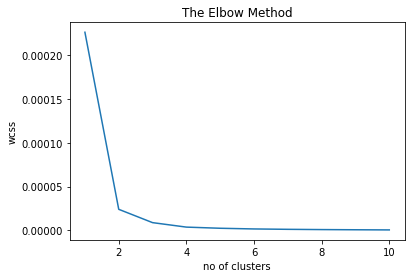

In [401]:
import matplotlib.pyplot as plt
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [402]:
wcss

[0.0002257663645531207,
 2.4116033709833018e-05,
 8.947411822676529e-06,
 3.849510571607045e-06,
 2.5395385237246787e-06,
 1.7556356006266652e-06,
 1.330545718605448e-06,
 1.0367353837349623e-06,
 8.310581171992722e-07,
 6.54813686669839e-07]

In [410]:
for i in range(1,150):
    labels = dbscan(x,wcss[1],i)
    cluster_label = get_cluster_count(labels)
    print(i, '-> 클러스터 수',len(cluster_label)-1)
    if len(cluster_label)-1==c:
        break

1 -> 클러스터 수 47
2 -> 클러스터 수 3
3 -> 클러스터 수 3
4 -> 클러스터 수 4
5 -> 클러스터 수 2


In [411]:

cluster_label = get_cluster_count(labels)
print(cluster_label)
cluster_label.remove(-1)
print(cluster_label)  

[-1, 2, 1]
[2, 1]


In [412]:
cluster_list = [ [] for i in range(len(cluster_label))]

for i in range(len(cluster_label)):
    for j in range(len(labels)):
        if cluster_label[i] == labels[j]:
            x_data = x.tolist()
            cluster_list[i].append([str(df['time'][j]), x_data[j][0], x_data[j][1]])

In [413]:
cluster_list

[[['2021-08-06 10:03:12', 35.9452749, 126.6827162],
  ['2021-08-06 10:03:17', 35.9452718, 126.68271370000001],
  ['2021-08-06 10:03:22', 35.9452731, 126.6827311],
  ['2021-08-06 10:03:27', 35.945267, 126.6827268],
  ['2021-08-06 10:03:32', 35.9452633, 126.68272720000002]],
 [['2021-08-06 10:03:42', 35.945224200000006, 126.68272569999999],
  ['2021-08-06 10:03:47', 35.945215000000005, 126.68271809999999],
  ['2021-08-06 10:03:52', 35.94521470000001, 126.68271999999999],
  ['2021-08-06 10:03:57', 35.945217, 126.68271940000001],
  ['2021-08-06 10:04:02', 35.9452185, 126.68271850000001],
  ['2021-08-06 10:04:07', 35.945218700000005, 126.6827189],
  ['2021-08-06 10:04:12', 35.9452186, 126.6827196],
  ['2021-08-06 10:04:17', 35.945218, 126.68271979999999],
  ['2021-08-06 10:04:22', 35.945218100000005, 126.6827196],
  ['2021-08-06 10:04:27', 35.9452179, 126.68271979999999],
  ['2021-08-06 10:04:32', 35.9452184, 126.68272009999998],
  ['2021-08-06 10:04:37', 35.9452166, 126.6827211],
  ['2021-

In [414]:
cluster_center = []
for i in range(len(cluster_list)):
    lat_sum = 0
    lon_sum = 0
    for j in range(len(cluster_list[i])):
        lat_sum += cluster_list[i][j][1]
        lon_sum += cluster_list[i][j][2]
    cluster_center.append([lat_sum / len(cluster_list[i]) , lon_sum / len(cluster_list[i])])

In [415]:
for i in range(len(cluster_center)):
    print(i+1, "->", cluster_center[i])

1 -> [35.945270019999995, 126.68272300000001]
2 -> [35.94521644447948, 126.68272019227119]


In [416]:
import numpy as np
import folium
from matplotlib import pyplot as plt
import matplotlib as mpl

lower_left = [35.94053805, 126.677630592098]
upper_right = [35.951225, 126.689017999998]
m = folium.Map(zoom_start = 15, location=[35.945881525000004, 126.683324296048])

for i in range(len(cluster_center)):
    folium.Marker(location=[cluster_center[i][0], cluster_center[i][1]], popup = (i+1)).add_to(m)

m

In [396]:
place_list = []
addr_list = []
for i in range(len(cluster_center)):
    addr, roadaddr,building = kakao_reverse_geocode(cluster_center[i][0],cluster_center[i][1])
    for j in addr:
        addr_list.append(j)
        place = kakao_get_place_addr(j)
        if place[0] == "no results":
            place = building
        print(i+1, "->" ,j)
        print(place)
        place_list.append(place)

1 -> 전북 군산시 미룡동 885-1
['no results']
2 -> 전북 군산시 미룡동 919
['no results']
3 -> 전북 군산시 미룡동 919
['no results']


In [156]:
poi_candidate = pd.read_csv(r"./poi_candidate.csv",encoding='utf-8')
poi_candidate

,상호명,유형,주소,lat,lon
0,긱스타PC클럽,"가정,생활 > 여가시설 > 게임방,PC방",전북 군산시 미룡동 879-1,35.945200,126.686392
1,미니스톱 군산대정문점,"가정,생활 > 편의점 > 미니스톱",전북 군산시 미룡동 879-1,35.945348,126.686321
2,파리바게뜨 군산미룡점,"음식점 > 간식 > 제과,베이커리 > 파리바게뜨",전북 군산시 미룡동 879-2,35.945372,126.686808
3,올리브영 군산대점,"가정,생활 > 드럭스토어 > 올리브영",전북 군산시 미룡동 879-2,35.945397,126.686750
4,노다지감자탕,음식점 > 한식 > 감자탕,전북 군산시 미룡동 364-5,35.945666,126.688248
5,GS25 군산대점,"가정,생활 > 편의점 > GS25",전북 군산시 미룡동 879-2,35.945039,126.686859
6,다이소 군산대점,"가정,생활 > 생활용품점 > 다이소",전북 군산시 미룡동 879-1,35.944976,126.686323
7,김현중내과의원,"의료,건강 > 병원 > 내과",전북 군산시 미룡동 880-1,35.945332,126.687163
8,미룡종로약국,"의료,건강 > 약국",전북 군산시 미룡동 880-1,35.945397,126.687049
9,글로리마트,"가정,생활 > 슈퍼마켓",전북 군산시 미룡동 876-1,35.946496,126.687075


In [89]:
from haversine import haversine
dist_list = []
result_place = []
for i in range(len(addr_list)):
    dist = 0
    cnt = 0
    for k in range(len(poi_candidate)):
        if addr_list[i] == poi_candidate["주소"][k]:
            #print(i, "place_list: ", place_list[i])
            print(i+1, "-> 매칭 장소: ", poi_candidate["상호명"][k])
            a =[]
            a.append(float(poi_candidate["lat"][k]))
            a.append(float(poi_candidate["lon"][k]))
            a = np.array(a)
            dist = haversine(a,np.array(cluster_center[i]), unit='km')
            print(dist)
            #print(dist)
            dist_list.append([i+1,dist, poi_candidate["상호명"][k]])

1 -> 매칭 장소:  군산대학교 디지털정보관
0.031099878509863534
1 -> 매칭 장소:  군산대학교 인문대학사회과학대학
0.34378734906184527
1 -> 매칭 장소:  군산대학교 자연과학대학4호관
0.15267342045549884
1 -> 매칭 장소:  군산대학교 종합교육관
0.18000401699730398
3 -> 매칭 장소:  GS25 군산대후문점
0.009990369649974401
4 -> 매칭 장소:  홈마트
0.010851508501679274
5 -> 매칭 장소:  긱스타PC클럽
0.01599570350658628
5 -> 매칭 장소:  미니스톱 군산대정문점
0.029114038539214696
5 -> 매칭 장소:  다이소 군산대점
0.012935208089292981


In [90]:
dist_list.sort(key = lambda dist_list:dist_list[1]) # 거리 순 정렬
dist_list

[[3, 0.009990369649974401, 'GS25 군산대후문점'],
 [4, 0.010851508501679274, '홈마트'],
 [5, 0.012935208089292981, '다이소 군산대점'],
 [5, 0.01599570350658628, '긱스타PC클럽'],
 [5, 0.029114038539214696, '미니스톱 군산대정문점'],
 [1, 0.031099878509863534, '군산대학교 디지털정보관'],
 [1, 0.15267342045549884, '군산대학교 자연과학대학4호관'],
 [1, 0.18000401699730398, '군산대학교 종합교육관'],
 [1, 0.34378734906184527, '군산대학교 인문대학사회과학대학']]

In [91]:
result_place = []
cluster_num = []
for i in range(len(cluster_center)):
    for j in range(len(dist_list)):
        if str(i+1) in str(dist_list[j][0]):
            print(i+1, "-> 매칭 장소: ", dist_list[j][2])
            result_place.append(dist_list[j])
            cluster_num.append(i+1)
            break

1 -> 매칭 장소:  군산대학교 디지털정보관
3 -> 매칭 장소:  GS25 군산대후문점
4 -> 매칭 장소:  홈마트
5 -> 매칭 장소:  다이소 군산대점


In [92]:
num = cluster = [i+1 for i in range(len(cluster_center))]
for i in num:
    if i not in cluster_num:
        result_place.append([i,0, "없음"])

In [93]:
result_place.sort(key = lambda result_place:result_place[0]) # 거리 순 정렬
result_place

[[1, 0.031099878509863534, '군산대학교 디지털정보관'],
 [2, 0, '없음'],
 [3, 0.009990369649974401, 'GS25 군산대후문점'],
 [4, 0.010851508501679274, '홈마트'],
 [5, 0.012935208089292981, '다이소 군산대점']]

In [94]:
for i in range(len(result_place)):
    print(i+1, '-> 매칭 장소:', result_place[i][2])
    print(result_place[i][1])

1 -> 매칭 장소: 군산대학교 디지털정보관
0.031099878509863534
2 -> 매칭 장소: 없음
0
3 -> 매칭 장소: GS25 군산대후문점
0.009990369649974401
4 -> 매칭 장소: 홈마트
0.010851508501679274
5 -> 매칭 장소: 다이소 군산대점
0.012935208089292981


In [95]:
def search_index(n, arr):
    for i in range(len(arr)):
        if arr[i][0] == n:
            return i

In [96]:
place

['다이소 군산대점',
 '미니스톱 군산대정문점',
 '라라코스트 군산대점',
 '네이처리퍼블릭 군산대점',
 '긱스타PC클럽',
 '머슬맥휘트니스클럽',
 '천원세상DC마트',
 '밀크밥버거 군산대점',
 '해피데이PC클럽',
 '60계치킨 군산나운미룡점',
 '감탄떡볶이 군산대점',
 '바이킹노래연습장',
 '주차장',
 '후먼빌딩']

In [ ]:
time = []
place = []
for i in range(len(cluster_list)):
    time.append(cluster_list[i][0][0]+" ~ "+cluster_list[i][len(cluster_list[i])-1][0])
    place.append(result_place[search_index(i+1, result_place)][2])

In [ ]:
place

In [ ]:
addr = []
lat = []
lon = []
type_list=[]
for i in range(len(place)):
    for j in range(len(poi_candidate)):
        if place[i] == poi_candidate['상호명'][j]:
            addr.append(poi_candidate['주소'][j])
            type_list.append(poi_candidate['유형'][j])
            lat.append(poi_candidate['lat'][j])
            lon.append(poi_candidate['lon'][j])
        elif 

In [ ]:
addr_list

In [ ]:
addr

In [ ]:
test = pd.DataFrame({'p_num':cluster_num,'time': time, 'place': place, 'type': type_list,'addr':addr_list,'lat':lat,'lon':lon})
test